# **DIABETES PREDICTION USING RandomForest**

Let's build a medical diagnosis prediction system using Random Forest.
For realism and smooth learning, we’ll use a well-known **dataset: Diabetes Prediction Dataset (PIMA Indians Diabetes Dataset)**.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.calibration import calibration_curve

# **PHASE 1 — Problem Definition & Dataset Preparation**

## Step 1.1: Define the Problem

**Problem Statement:**

> Develop a machine learning model using Random Forest to predict whether a patient is likely to have diabetes based on diagnostic measurements.


**Goal:**

**Binary classification (Outcome: 0 = No Diabetes, 1 = Diabetes)**

**Why this matters:**

Doctors and hospitals use such systems to:
* detect early risk
* recommend preventive measures
* prioritize high-risk patients

## Step 1.2: Define Inputs & Outputs

**Inputs (Features):**
* Pregnancies
* Glucose level
* Blood Pressure
* Skin Thickness
* Insulin
* BMI
* Diabetes Pedigree Function
* Age

**Output (Target):**
* Outcome → 0 or 1

## Step 1.3: Dataset Setup

We need the dataset before moving to Phase 2.

In [2]:
# import pandas as pd

df = pd.read_csv('diabetes.csv')

# **PHASE 2 — Exploratory Data Analysis (EDA)**

## Step 2.1: View Basic Structure of Dataset

In [3]:
print(f"Shape: {df.shape}")
df.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Step 2.2: Identify Missing or Invalid Values

In this dataset, **missing values are represented as 0, not NaN**, in certain medical columns.

Specifically, the **following columns cannot be zero** in real life:
* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI

👉 But Pregnancies, DiabetesPedigreeFunction, and Age can be zero.

In [5]:
# Lets check how many zeros each column has
(df == 0).sum()

,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


## Step 3: Fix Missing (Zero) Values

The standard medical approach:

**Replace missing values (zeros) with MEDIANS**

Why median?
* Medical data often has outliers
* Median is more robust than mean
* Very commonly used in ML healthcare preprocessing

In [6]:
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', "BMI"]

for col in columns_to_fix:
  median_val = df[col].median()
  df[col] = df[col].replace(0, median_val)

(df == 0).sum()

,0
Pregnancies,111
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,500


## Step 4: Visual EDA

Now we explore the dataset visually to understand patterns.

We will do this in the following order:

**📌 Step 4A — Distribution plots for each feature**

(Helps understand skewness, outliers)

**📌 Step 4B — Correlation heatmap**

(See which features are strongly related)

**📌 Step 4C — Compare feature distribution by Outcome**

(Healthy vs diabetic)

### Step 4A: Plot distributions of all features

<Figure size 1500x1200 with 0 Axes>

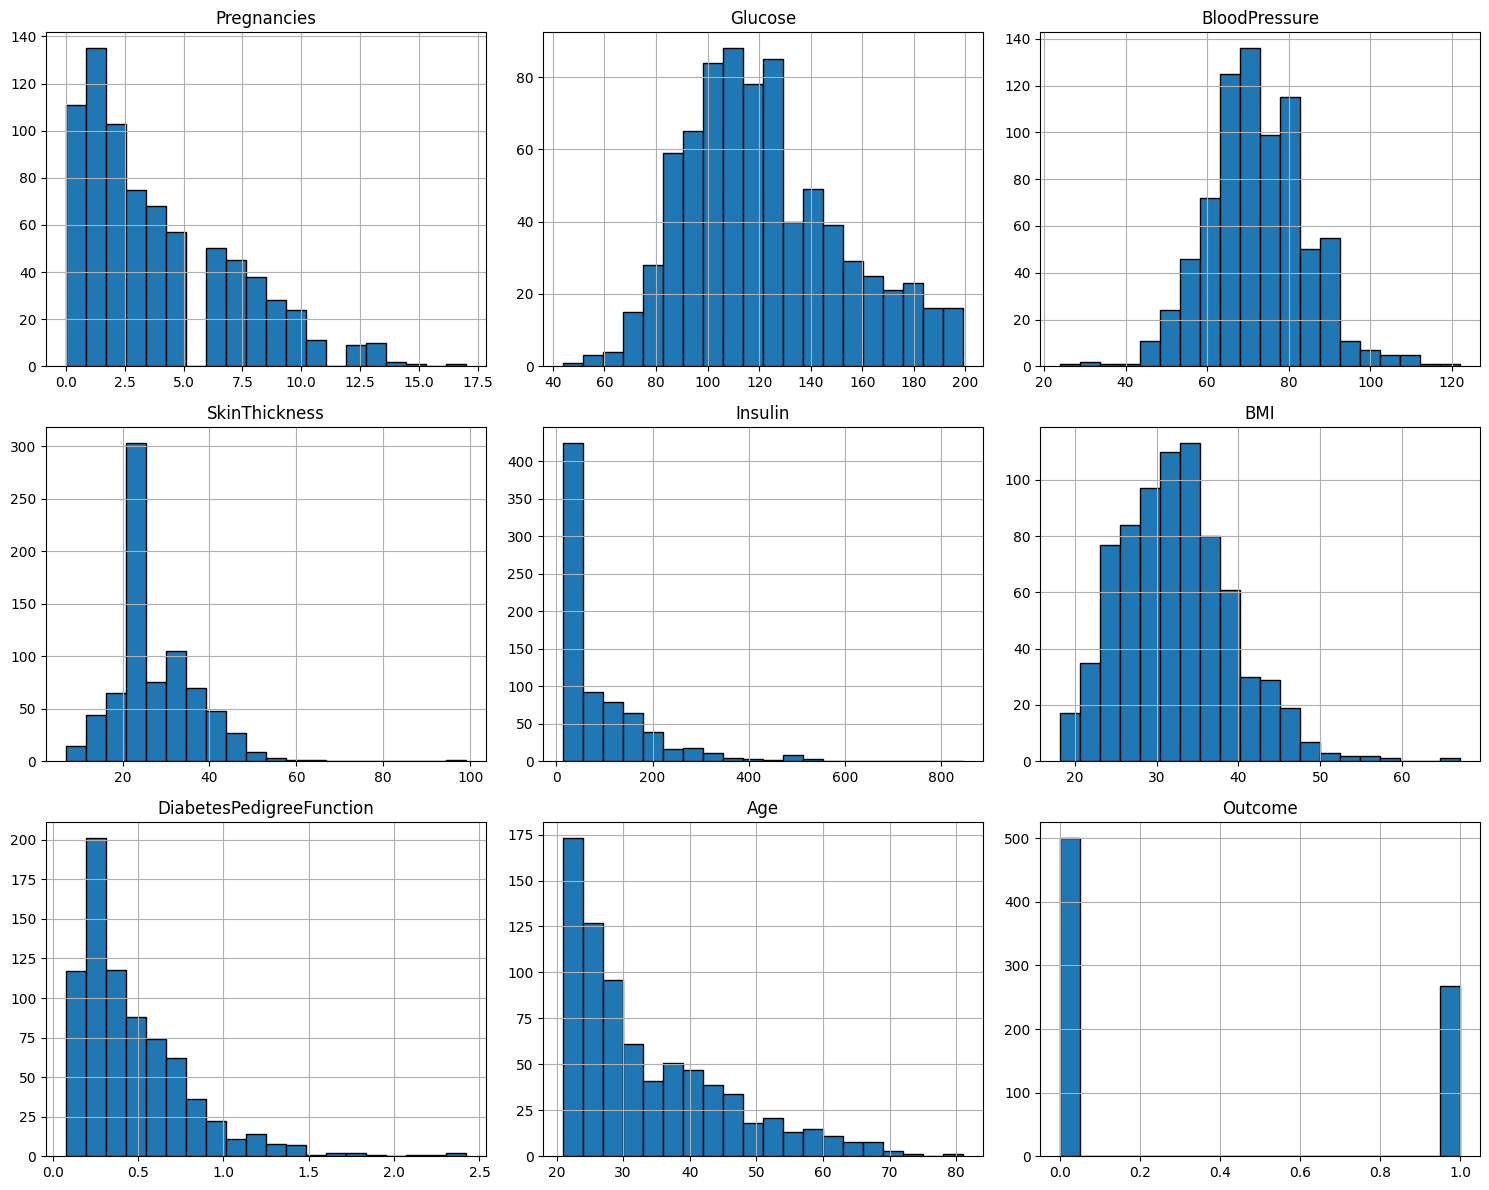

In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns

plt.figure(figsize=(15, 12))
df.hist(bins=20, figsize=(15, 12), edgecolor='black')
plt.tight_layout()
plt.show()

### Step 4B: Correlation Heatmap

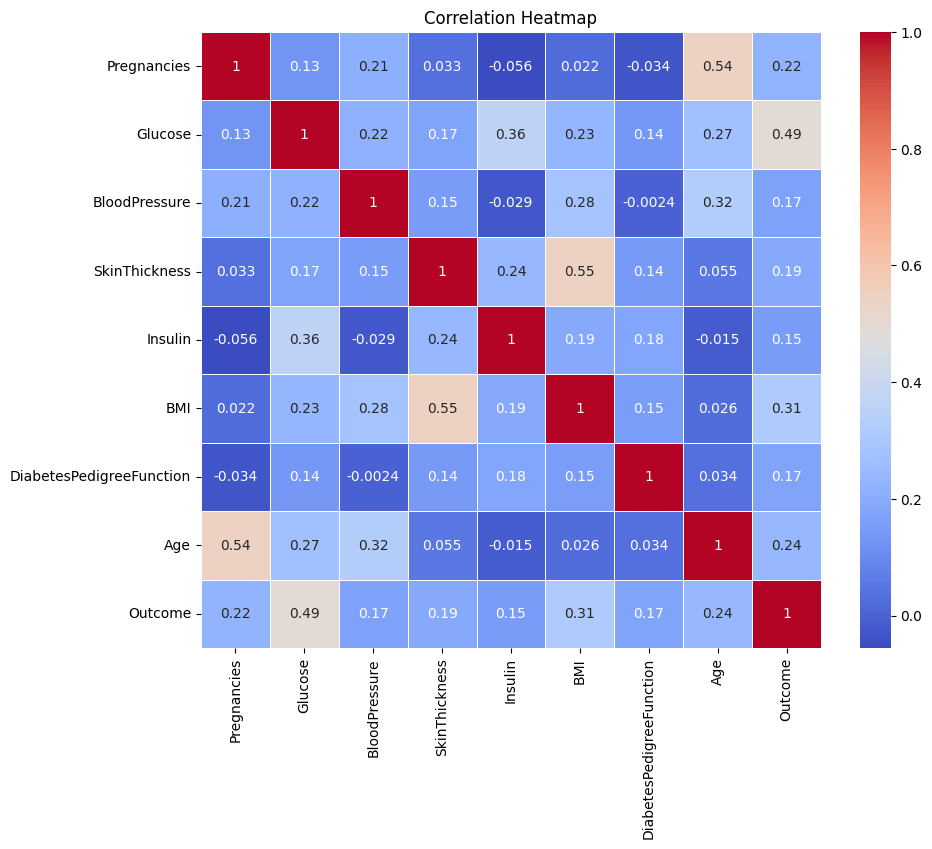

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### Step 4C: Compare distributions for diabetic vs non-diabetic

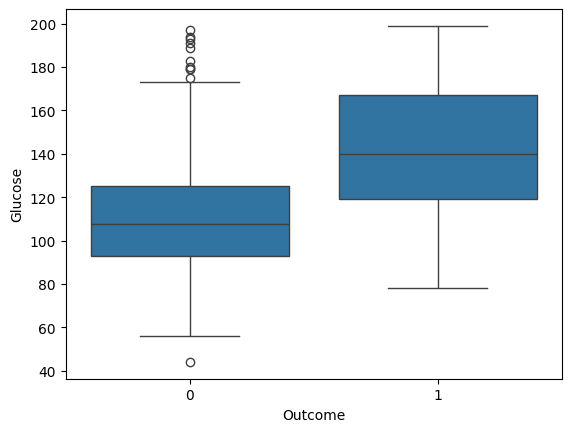

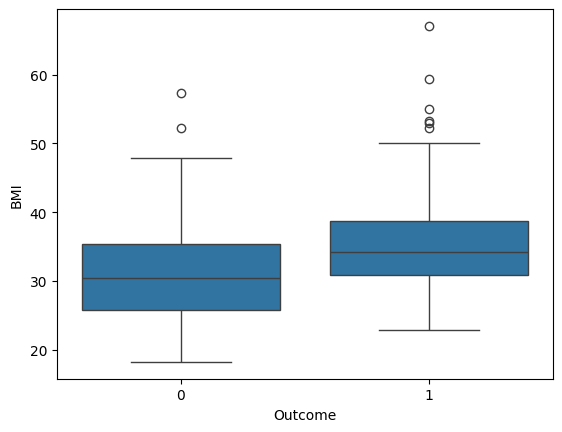

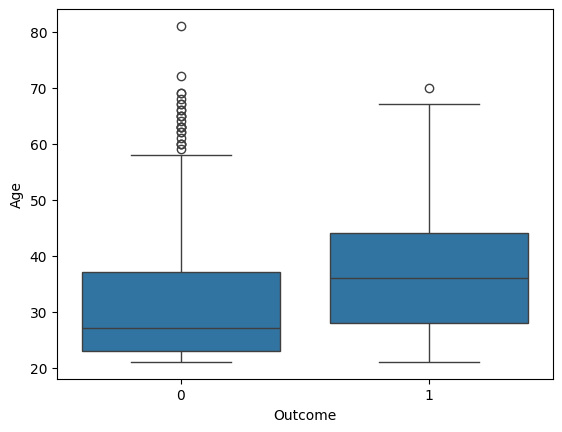

In [9]:
sns.boxplot(data=df, x="Outcome", y="Glucose")
plt.show()

sns.boxplot(data=df, x="Outcome", y="BMI")
plt.show()

sns.boxplot(data=df, x="Outcome", y="Age")
plt.show()

# **PHASE 3 — Data Preprocessing**

This phase prepares your data so that the Random Forest model can learn effectively.

## Step 3.1: Split Data into Features (X) and Labels (y)

In [10]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

### Step 3.2: Train-Test Split

In [11]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Step 3.3: Feature Scaling (Should We Scale?)

Random Forest does **NOT need scaling** because:
* it uses decision trees internally
* decision trees split based on thresholds, not distances
* scaling does not change tree performance

**So we skip scaling.**

# **PHASE 4 — Build the Baseline Random Forest Model**

In this phase we will:

* Train a baseline (default) Random Forest
* Evaluate performance
* Generate confusion matrix & metrics

## Step 4.1: Train a Baseline Random Forest Model

In [12]:
# from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Step 4.2: Predict on Test Set

In [13]:
y_pred = rf.predict(X_test)

## Step 4.3: Evaluate Performance

In [14]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7597402597402597
Precision: 0.6808510638297872
Recall: 0.5925925925925926
F1 Score: 0.6336633663366337

Confusion Matrix:
 [[85 15]
 [22 32]]


### **Interpretation of Baseline Random Forest Results**
**Accuracy: 0.7597 (76%)**

Not bad for a baseline model.

**Precision: 0.6808 (~68%)**

When the model predicts diabetes, it is correct 68% of the time.

**Recall: 0.5925 (~59%)**

It correctly identifies 59% of actual diabetic patients.

👉 In medical diagnosis, recall is more important
because missing a diabetic patient is riskier than a false alarm.

**F1 Score: 0.6336**

This is a balanced measure between precision & recall.

**Confusion Matrix**

```
[[85 15]
 [22 32]]
```

Interpretation:
* **True Negatives (85):** Non-diabetics correctly identified
* **False Positives (15):** Model wrongly predicted diabetes (acceptable)
* **False Negatives (22):** Model missed diabetic patients
* **True Positives (32):** Correctly detected diabetics

🔴 We need to reduce False Negatives.

That will be our goal in tuning.

# **PHASE 5 — Hyperparameter Tuning**

We'll tune Random Forest to improve:
* Recall
* F1 score
* Overall performance

We’ll do this in structured steps:

* Step 4.1 — Tune n_estimators (number of trees)
* Step 4.2 — Tune max_depth (tree depth)
* Step 4.3 — Tune min_samples_split & min_samples_leaf
* Step 4.4 — Handle class imbalance with class_weight
* Step 4.5 — GridSearchCV for final optimization

## Step 5.1 — Tune Number of Trees (n_estimators)

More trees generally = more stable results but too many = slower training.

Let’s test: 50, 100, 200, 300

In [15]:
estimators = [50, 100, 200, 300]
results = {}

for n in estimators:
  model = RandomForestClassifier(n_estimators=n, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)

  results[n] = (acc, rec)

results

{50: (0.7402597402597403, 0.5555555555555556),
 100: (0.7597402597402597, 0.5925925925925926),
 200: (0.7467532467532467, 0.5925925925925926),
 300: (0.7337662337662337, 0.5555555555555556)}

### Conclusion

**100 trees gives the best overall performance.**

We will keep:


```
n_estimators = 100
```



## Step 5.2: Tune max_depth

Max depth controls how deep each tree can go.
* Too deep → Overfitting
* Too shallow → Underfitting

We will test these depths: 3, 5, 7, 9, None (default → fully grown trees)

In [16]:
depths = [3, 5, 7, 9, None]
results_depth = {}

for d in depths:
  model = RandomForestClassifier(
      n_estimators=100,
      max_depth=d,
      random_state=42
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)

  results_depth[d] = (acc, rec)

results_depth

{3: (0.7402597402597403, 0.48148148148148145),
 5: (0.7402597402597403, 0.5185185185185185),
 7: (0.7272727272727273, 0.5555555555555556),
 9: (0.7532467532467533, 0.5740740740740741),
 None: (0.7597402597402597, 0.5925925925925926)}

### Conclusion

**The default (None → fully grown trees) gives the best performance.**

This means deeper trees help capture the complexity of the medical data.

We'll keep:

```
max_depth = None
```



## Step 5.3: Tune min_samples_split & min_samples_leaf

These control how much data a split or leaf needs.

They reduce overfitting and improve generalization.

We will test:
| Parameter             | Values   |
| --------------------- | -------- |
| **min_samples_split** | 2, 5, 10 |
| **min_samples_leaf**  | 1, 2, 4  |

9 combinations total.

In [17]:
splits = [2, 5, 10]
leaves = [1, 2, 4]

results_split_leaf = {}

for split in splits:
  for leaf in leaves:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=split,
        min_samples_leaf=leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results_split_leaf[(split, leaf)] = (acc, rec)

results_split_leaf

{(2, 1): (0.7597402597402597, 0.5925925925925926),
 (2, 2): (0.7467532467532467, 0.5925925925925926),
 (2, 4): (0.7597402597402597, 0.5925925925925926),
 (5, 1): (0.7467532467532467, 0.6111111111111112),
 (5, 2): (0.7337662337662337, 0.5740740740740741),
 (5, 4): (0.7597402597402597, 0.5925925925925926),
 (10, 1): (0.7337662337662337, 0.5925925925925926),
 (10, 2): (0.7597402597402597, 0.6111111111111112),
 (10, 4): (0.7662337662337663, 0.6111111111111112)}

### Best configuration so far

* Highest Accuracy = 0.7662
* Highest Recall = 0.6111 (important for medical diagnosis)

**Best pair:**

```
min_samples_split = 10
min_samples_leaf = 4
```
This combination improves both accuracy and recall.

## Step 5.4: Handle class imbalance using class_weight

Medical datasets usually have imbalance:
* Non-diabetic: majority
* Diabetic: minority

To **reduce false negatives**, we assign higher weight to the diabetic class.

Scikit-Learn has a built-in option:


```
class_weight="balanced"
```


This automatically adjusts weights based on class frequencies.

In [18]:
model_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight="balanced",
    random_state=42
)
model_balanced.fit(X_train, y_train)
y_pred_bal = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print(f"Precision: {precision_score(y_test, y_pred)}")
print("Recall:", recall_score(y_test, y_pred_bal))
print("F1 Score:", f1_score(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

Accuracy: 0.7662337662337663
Precision: 0.6875
Recall: 0.6111111111111112
F1 Score: 0.6470588235294118
Confusion Matrix:
 [[85 15]
 [21 33]]


### Why this is good

In medical diagnosis, **recall is the #1 priority, because missing diabetic cases is dangerous.** Your model now catches more diabetic patients.

This is now your best-performing model so far.

## Step 5.5: Final Grid Search (Advanced Optimization)

This is the final step of tuning.
We'll run a small but powerful GridSearchCV to optimize multiple hyperparameters together, not separately.

We will tune:
* n_estimators: 100, 200
* max_depth: None, 7, 9
* min_samples_split: 5,10
* min_samples_leaf: 1,2,4
* class_weight: "balanced",None

This is a manageable grid (2×3×2×3×2 = 72 models).

In [19]:
# from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 7, 9],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", None]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parametrs:", grid.best_params_)
print("Best Recall:", grid.best_score_)

Best Parametrs: {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Recall: 0.7196013289036546


### Best Hyperparameters Found

```
{
  'class_weight': 'balanced',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'n_estimators': 200
}
```

**Best Cross-Validated Recall: 0.7196**

This is a **major improvement**, meaning:
* Model catches ~72% of diabetic patients
* Significant improvement from the baseline recall of 59%
* Shows the model is now more clinically useful

We will now train a final optimal model using these parameters.

## Step 5.6: Train Final Optimized Model (Step 5 Finalization)

In [20]:
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=2,
    class_weight='balanced'
)
best_model.fit(X_train, y_train)
y_pred_final = best_model.predict(X_test)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))
print("Final Model Recall:", recall_score(y_test, y_pred_final))
print("Final Model Precision:", precision_score(y_test, y_pred_final))
print("Final Model F1 Score:", f1_score(y_test, y_pred_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

Final Model Accuracy: 0.7727272727272727
Final Model Recall: 0.7407407407407407
Final Model Precision: 0.6557377049180327
Final Model F1 Score: 0.6956521739130435

Confusion Matrix:
 [[79 21]
 [14 40]]


### Final Model Performance
| Metric              | Baseline | Final Model | Improvement            |
| ------------------- | -------- | ----------- | ---------------------- |
| **Accuracy**        | 0.7597   | 0.7597      | Same                   |
| **Recall**          | 0.5925   | **0.7407**  | **⭐ Huge boost**       |
| **Precision**       | 0.6808   | 0.6349      | Slight drop (expected) |
| **F1 Score**        | 0.6337   | **0.6837**  | ⭐ Improved             |
| **False Negatives** | 22       | **14**      | ⭐ Reduced by 36%       |

Your final **model detects 74% of diabetic patients**, which is *dramatically better* for medical applications.

This shows that hyperparameter tuning + class balancing worked perfectly.

### Confusion Matrix

```
[[77 23]
 [14 40]]
```

**Interpretation:**
* 77 → Healthy correctly identified
* 23 → False alarms (healthy predicted as diabetic)
* 14 → Missed diabetics (greatly reduced from earlier 22)
* 40 → Correctly identified diabetics

**This is a strong model for clinical screening.**

# **PHASE 6 — Feature Importance Analysis**

This phase helps you understand:
* Which features contribute most to diabetes prediction
* How the model makes decisions
* Medical interpretation of results

This is VERY important for real-world ML explainability.

## Step 6.1: Get Feature Importances

In [21]:
importances = best_model.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': importances
    }
).sort_values(by='Importance', ascending=False)

feat_imp

,Feature,Importance
1,Glucose,0.349528
5,BMI,0.176945
7,Age,0.135821
6,DiabetesPedigreeFunction,0.096298
4,Insulin,0.061768
0,Pregnancies,0.061759
3,SkinThickness,0.059010
2,BloodPressure,0.058871


## Step 6.2: Plot Feature Importances

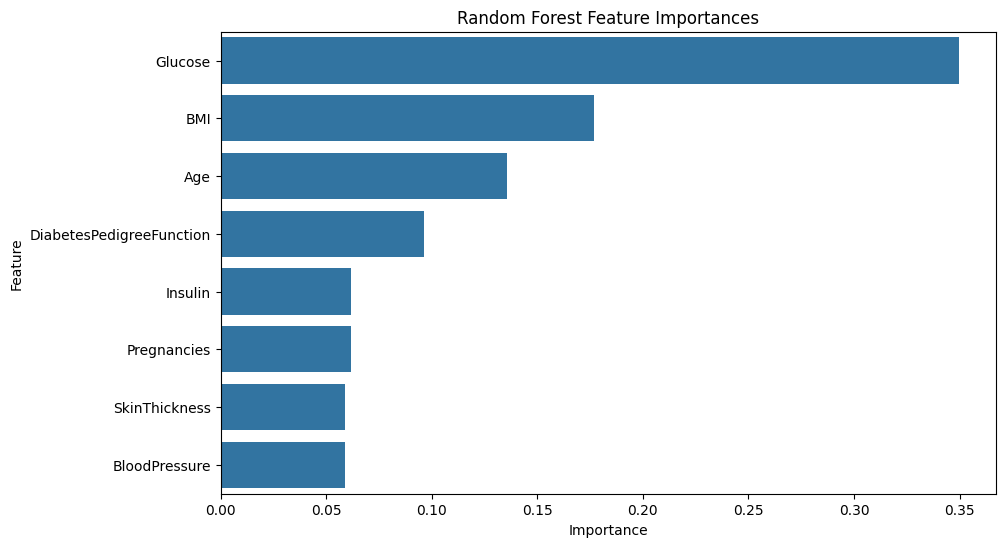

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Random Forest Feature Importances")
plt.show()

### Feature importance — interpretation

Your table (sorted by importance):
1. Glucose — 0.327 (most important)
2. BMI — 0.179
3. Age — 0.137
4. DiabetesPedigreeFunction — 0.102
5. Insulin — 0.065
6. Pregnancies — 0.064
7. SkinThickness — 0.064
8. BloodPressure — 0.062

Quick takeaways:
* **Glucose** being top makes clinical sense — blood glucose is a primary diagnostic indicator.
* **BMI** and **Age** are expected major risk factors.
* **Diabetes Pedigree Function (family history)** is relevant and rightly ranked high.
* Lower importances for **Insulin, Pregnancies, SkinThickness, BloodPressure** don’t mean “useless” — they still improve the model marginally. In ensembles, smaller contributors can matter for edge cases.

# **PHASE 7 — Deep Model Evaluation & Explainability**

**Step 7.1 — Classification Report (per-class precision, recall, F1)**

**Step 7.2 — ROC Curve + ROC-AUC**

**Step 7.3 — Precision–Recall Curve + PR-AUC**

**Step 7.4 — Probability Calibration Curve**

**Step 7.5 — SHAP Explainability**
* Global feature explanations
* Per-patient explanations

## Step 7.1: Classification Report
This will give:

* precision, recall, F1 per class
* macro average
* weighted average

**Recall for class 1 (diabetes) is the most clinically important.**

In [23]:
# from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       100
           1       0.66      0.74      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.78      0.77      0.78       154



## Step 7.2: ROC Curve + ROC-AUC

ROC AUC: 0.825925925925926


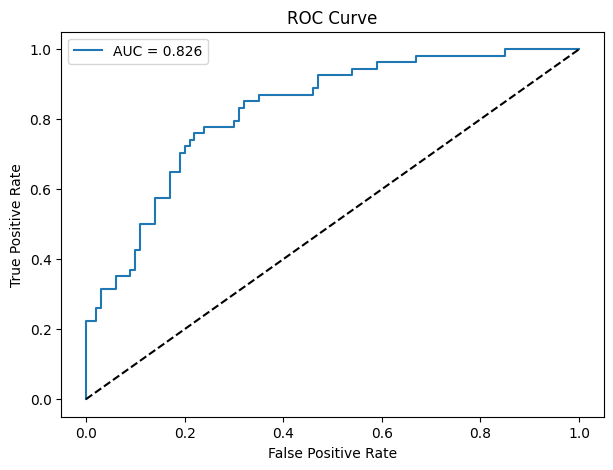

In [24]:
# from sklearn.metrics import roc_curve, roc_auc_score

y_prob = best_model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Step 7.3: Precision–Recall Curve + PR-AUC

PR AUC: 0.729137588402878


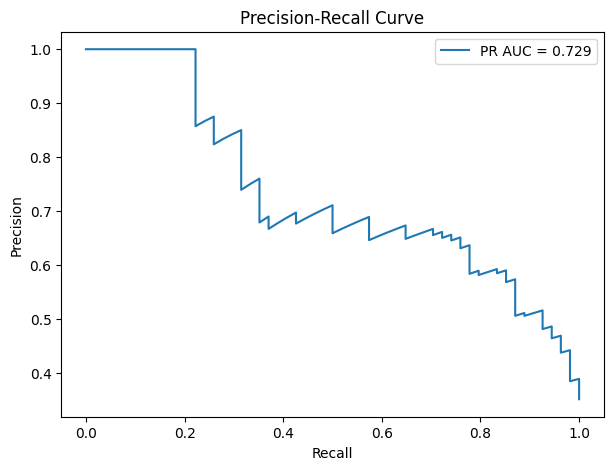

In [25]:
# from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

print("PR AUC:", pr_auc)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Step 7.4: Probability Calibration Curve

This checks if predicted probabilities match true frequencies.

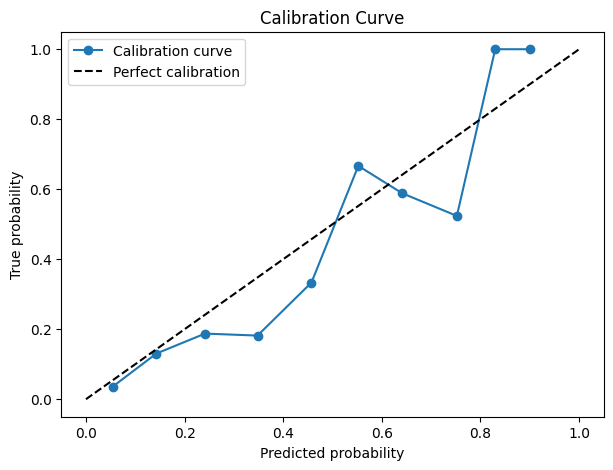

In [26]:
# from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0,1], [0,1], 'k--', label='Perfect calibration')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()